In [258]:
# import packages
from __future__ import print_function
import requests
import json
import re
from bs4 import BeautifulSoup
import pandas as pd
pd.options.display.max_columns = 10
pd.options.mode.chained_assignment = None
import numpy as np
from datetime import datetime
from tqdm import tqdm
from matplotlib import pyplot as plt
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from string import punctuation
from collections import Counter
from functools import reduce
from selenium import webdriver


Methods for scraping each page

In [332]:
def getUrls(page_no): #takes in page number
    source_url = 'https://www.businesstimes.com.sg/search/coronavirus?page='+str(page_no)
    res = requests.get(source_url)
    bsoup = BeautifulSoup(res.content, features = 'html.parser')
    contents = bsoup.findAll("div",{"class":"media-body"})
    urls = []
    for content in contents:
        urls.append(content.a['href'])
    return urls
def getHeader(page_no):
    source_url = 'https://www.businesstimes.com.sg/search/coronavirus?page='+str(page_no)
    res = requests.get(source_url)
    bsoup = BeautifulSoup(res.content, features = 'html.parser')
    contents = bsoup.findAll("div",{"class":"media-body"})
    headers = []
    for content in contents:
        headers.append(content.a.text)
    return headers
def getDesc(page_no):
    source_url = 'https://www.businesstimes.com.sg/search/coronavirus?page='+str(page_no)
    res = requests.get(source_url)
    bsoup = BeautifulSoup(res.content, features = 'html.parser')
    contents = bsoup.findAll("div",{"class":"media-body"})
    descs = []
    for content in contents:
        descs.append(content.p.text)
    return descs
def getDates(page_no):
    source_url = 'https://www.businesstimes.com.sg/search/coronavirus?page='+str(page_no)
    res = requests.get(source_url)
    bsoup = BeautifulSoup(res.content, features = 'html.parser')
    contents = bsoup.findAll("div",{"class":"media-body"})
    dates = []
    for content in contents:
        dates.append(content.time.text)
    return dates
def getCategory(page_no):
    source_url = 'https://www.businesstimes.com.sg/search/coronavirus?page='+str(page_no)
    res = requests.get(source_url)
    bsoup = BeautifulSoup(res.content, features = 'html.parser')
    contents = bsoup.findAll("div",{"class":"media-body"})
    categories = []
    for content in contents:
        url_string = content.a['href']
        categories.append(url_string.split("/")[3])
    return categories

Get news on Coronavirus from Business Times

In [333]:
def getNews():
    all_urls = []
    all_headers = []
    all_descs = []
    all_dates = []
    all_categories = []
    for page_no in range(1,11):
        all_urls += getUrls(page_no)
        all_headers += getHeader(page_no)
        all_descs += getDesc(page_no)
        all_dates += getDates(page_no)
        all_categories += getCategory(page_no)
    news_df = {'Date':all_dates, 'Header':all_headers, 'Description':all_descs, 
               'Category':all_categories, 'URLS':all_urls, }
    news = pd.DataFrame(data = news_df)
    try:
        news.to_csv('/Users/ernestng/Desktop/projects/webscrap/news.csv', encoding='utf-8', index=False)
    except:
        news.to_csv('/Users/ernestng/Desktop/projects/webscrap/news.csv', index=False, encoding='utf-8')
    return news
news = getNews()

Work on scraped data stored in csv file

In [334]:
news = pd.read_csv('/Users/ernestng/Desktop/projects/webscrap/news.csv')
news.head()

,Date,Header,Description,Category,URLS
0,06 Apr 2020,BMW Q1 sales slump as coronavirus hits all mar...,[MUNICH] BMW AG's first-quarter car deliveries...,transport,https://www.businesstimes.com.sg/transport/bmw...
1,06 Apr 2020,Philippines' Nickel Asia to resume ore shipmen...,"[MANILA] Nickel Asia Corp, the Philippines' la...",energy-commodities,https://www.businesstimes.com.sg/energy-commod...
2,06 Apr 2020,"Spit, sweat and shaking on it: Three sports ha...",[PARIS] As the coronavirus brings the internat...,life-culture,https://www.businesstimes.com.sg/life-culture/...
3,06 Apr 2020,"American joins United, others in suspending mo...",[NEW YORK] American Airlines Group Inc said la...,transport,https://www.businesstimes.com.sg/transport/ame...
4,06 Apr 2020,Japan animal ventilator maker looks to boost o...,[KAWAGUCHI] A Japanese medical equipment maker...,consumer,https://www.businesstimes.com.sg/consumer/japa...


Distribution of Categories related to COVID-19 in our dataset

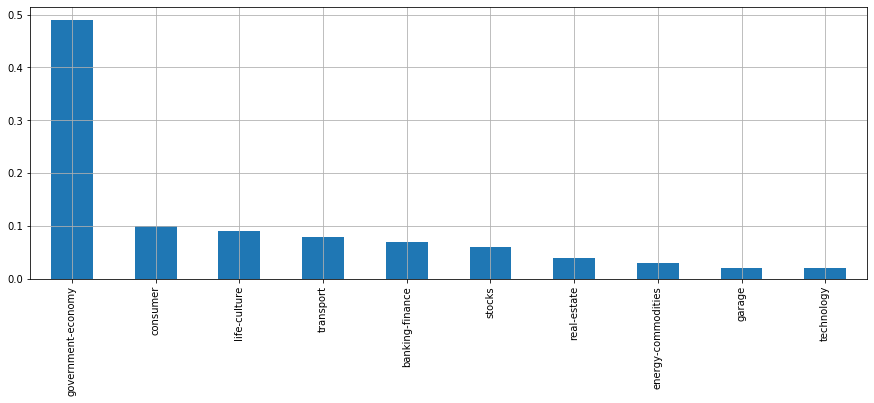

In [335]:
news.Category.value_counts(normalize=True).plot(kind='bar', grid=True,figsize=(15, 5))

In [336]:
news = news.drop_duplicates('Description')
news = news[~news['Description'].isnull()]
#news = news[(news.Description.map(len) > 140) & (news.Description.map(len) <= 300)]

Distribution of description lengths

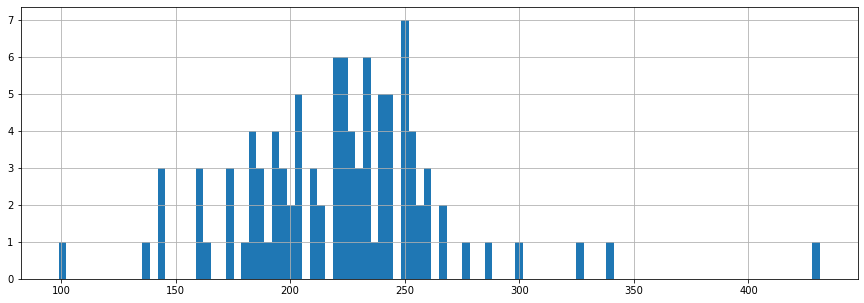

In [337]:
news.Description.map(len).hist(figsize=(15, 5), bins=100)

Text preprocessing for Description column


In [338]:
stop_words = []

f = open('/Users/ernestng/Desktop/projects/webscrap/stopwords.txt', 'r')
for l in f.readlines():
    stop_words.append(l.replace('\n', ''))
    
additional_stop_words = ['t', 'will']
stop_words += additional_stop_words

def _removeNonAscii(s): 
    return "".join(i for i in s if ord(i)<128)

def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = text.replace('(ap)', '')
    text = re.sub(r"\'s", " is ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r'\W+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r"\\", "", text)
    text = re.sub(r"\'", "", text)    
    text = re.sub(r"\"", "", text)
    text = re.sub('[^a-zA-Z ?!]+', '', text)
    text = _removeNonAscii(text)
    text = text.strip()
    return text
#function to clean and tokenize texts
def tokenizer(text):
    text = clean_text(text)    
    tokens = [word_tokenize(sent) for sent in sent_tokenize(text)]
    tokens = list(reduce(lambda x,y: x+y, tokens))
    tokens = list(filter(lambda token: token not in (stop_words + list(punctuation)) , tokens))
    return tokens


I tokenize each description and place all under 'tokens' column in the news dataset

In [339]:
news['tokens'] = list(map(tokenizer,news['Description']))
#see how the descriptions are tokenized
for description, tokens in zip(news['Description'].head(5), news['tokens'].head(2)):
    print('---------------------------------------------------------------------------------------------------------------------')
    print('description:', description)
    print()
    print('tokens:', tokens)
print('---------------------------------------------------------------------------------------------------------------------')


---------------------------------------------------------------------------------------------------------------------
description: [MUNICH] BMW AG's first-quarter car deliveries sank by about 21 per cent to 477,111 as the coronavirus pandemic closed showrooms all over the world and idled production lines.

tokens: ['munich', 'bmw', 'ag', 'is', 'first', 'quarter', 'car', 'deliveries', 'sank', 'by', 'about', 'per', 'cent', 'to', 'as', 'the', 'coronavirus', 'pandemic', 'closed', 'showrooms', 'all', 'over', 'the', 'world', 'and', 'idled', 'production', 'lines']
---------------------------------------------------------------------------------------------------------------------
description: [MANILA] Nickel Asia Corp, the Philippines' largest nickel ore miner and exporter, said on Monday its two units in Surigao del Norte province will resume ore shipments as the local government has allowed mining operations to resume after a suspension to curb the potential spread of the coronavirus.

toke

See most frequent tokens in each category

In [340]:
def keywords(category):
    tokens = news[news['Category'] == category]['tokens']
    alltokens = []
    for token_list in tokens:
        alltokens += token_list
    counter = Counter(alltokens)
    return counter.most_common(10)

for category in set(news['Category']):
    print('---------------------------------------------------------------------------------------------------------------------')
    print('Category :', category)
    print('top 10 keywords:', keywords(category))
print('---------------------------------------------------------------------------------------------------------------------')


---------------------------------------------------------------------------------------------------------------------
Category : energy-commodities
top 10 keywords: [('the', 6), ('in', 4), ('as', 3), ('to', 3), ('coronavirus', 3), ('nickel', 2), ('ore', 2), ('on', 2), ('resume', 2), ('their', 2)]
---------------------------------------------------------------------------------------------------------------------
Category : real-estate
top 10 keywords: [('the', 11), ('a', 4), ('of', 4), ('to', 4), ('in', 3), ('coronavirus', 3), ('and', 2), ('have', 2), ('said', 2), ('on', 2)]
---------------------------------------------------------------------------------------------------------------------
Category : stocks
top 10 keywords: [('the', 16), ('on', 8), ('of', 8), ('coronavirus', 6), ('and', 5), ('as', 5), ('a', 5), ('to', 4), ('shares', 3), ('in', 3)]
---------------------------------------------------------------------------------------------------------------------
Category : garage
top